# Training a MIL model for cancer detection in Whole Slide Images

Detecting cancerous tissue in Whole Slide Images (WSIs) is a critical task in pathology. Traditionally, this involves a pathologist manually examining the entire slide - a process that is not only time-consuming but also subject to variability in human judgment. With recent advancements in machine learning, however, it is now possible to develop models that can assist or even automate parts of this diagnostic workflow.

The common fully supervised approach would be as follows: the WSI is divided into smaller patches, each of which is labeled as either cancerous or non-cancerous. While effective, this method is heavily reliant on large amounts of annotated data. Since each WSI contains thousands of patches, labeling every patch requires significant effort from expert pathologists, making the process expensive and often impractical at scale.

To address this limitation, Multiple Instance Learning (MIL) offer a more feasible alternative. Instead of labeling individual patches, each WSI is given a single label—cancerous or non-cancerous—without detailed annotations at the patch level. This drastically reduces the annotation burden, but also introduces new challenges in model training. In this tutorial, we explore the MIL framework to tackle this problem, enabling us to train an effective cancer detection model with only slide-level labels.

## The data

In this tutorial, we will use the CAMELYON16 dataset, a public dataset for the detection of breast cancer metastasis. The original version of this dataset can be found [here](https://camelyon16.grand-challenge.org/). 

We have extracted patches from each WSI using the [CLAM tool](https://github.com/mahmoodlab/CLAM). Let's take a look at some of them. First, we define an auxiliary function to extract the patches from a `.tif` file. The coordinates of the patches—also provided by CLAM—are used to locate and crop the relevant regions from the slide.

In [1]:
import tifffile
import zarr
import cv2
import numpy as np

def read_wsi_patches(wsi_path, coords_path, size=512, resize_size=10):

    store = tifffile.imread(wsi_path, aszarr=True)
    wsi = zarr.open(store, mode='r')[0]

    inst_coords = np.load(coords_path, allow_pickle=True)
    bag_len = len(inst_coords)
    patches_list = []
    row_list = []
    column_list = []
    for i in range(bag_len):
        coord = inst_coords[i]
        x, y = coord      

        patch = wsi[y:y+size, x:x+size]
        patch = cv2.resize(patch, (resize_size, resize_size))
        patches_list.append(patch)

        row = int(y / size)
        column = int(x / size)
        row_list.append(row)
        column_list.append(column)

    row_array = np.array(row_list)
    column_array = np.array(column_list)

    row_array = row_array - row_array.min()
    column_array = column_array - column_array.min()

    return patches_list, row_array, column_array

Let's load the patches from a WSI using this function:

In [2]:
import os

img_dir = "/data/datasets/CAMELYON16/original/images/"
coord_dir = "/data/datasets/CAMELYON16/patches_512_preset/coords/"

wsi_name = "test_016"

wsi_path = os.path.join(img_dir, wsi_name + ".tif")
coords_path = os.path.join(coord_dir, wsi_name + ".npy")

patches_list, row_array, column_array = read_wsi_patches(wsi_path, coords_path, size=512, resize_size=10)

Now that we have the patches, we can visualize the WSI using the `patches_to_canvas` from the `torchmil.visualize` module:

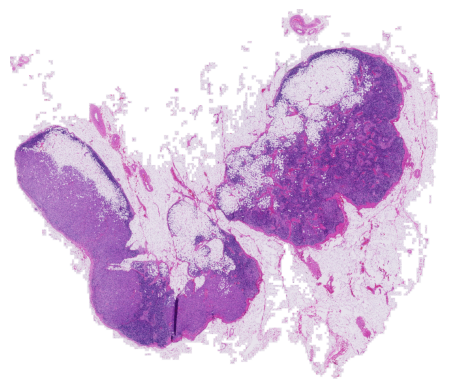

In [3]:
from torchmil.visualize import patches_to_canvas

canvas = patches_to_canvas(patches_list, row_array, column_array, 10)
import matplotlib.pyplot as plt

plt.imshow(canvas)
plt.axis('off')
plt.show()

## Creating the dataset

Let's create a dataset for the CAMELYON16 dataset. Since training a MIL model directly on the patch images is computationally intractable, we are going to use pre-computed features. This is a common practice for MIL, since data rarely fits in memory. We have processed the CAMELYON16 dataset to be used for MIL binary classification problems, see the [Hugging Face Hub](https://huggingface.co/datasets/Franblueee/Camelyon16_MIL/). We offer some choices of features, including the ones extracted using the [Barlow Twins method](https://arxiv.org/abs/2103.03230) and the foundation model [UNI](https://huggingface.co/MahmoodLab/UNI).



!!! example "Breast cancer detection as a MIL problem"
    
    We model each Whole Slide Image (WSI) as a bag of instances, where each instance corresponds to a patch extracted from the WSI.
    
    Each patch has an associated (but unknown) label denoted by $\mathbf{y} = \left[ y_1, \ldots, y_N \right]^\top \in {0, 1}^N$, where $y_i = 1$ if the patch contains evidence of breast cancer, and $y_i = 0$ otherwise. Importantly, these instance-level labels are not available during training.

    Instead, we have access only to bag-level labels, denoted by $Y \in {0, 1}$, which indicate whether the entire WSI contains cancerous tissue. The relationship between the instance labels and the bag label follows a standard Multiple Instance Learning (MIL) assumption:

    $$ Y = \max \left\{ y_1, \ldots, y_N \right\} $$

    In other words, a WSI is labeled as positive ($Y = 1$) if at least one of its patches is cancerous ($y_i = 1$), and negative ($Y = 0$) if none of the patches contain cancer. This formulation allows us to train models using only weak supervision, where only bag-level labels are available, while the finer-grained instance labels remain latent.

The `torchmil` library provides a convenient way to handle datasets specifically designed for MIL tasks. In this case, we will be using the `torchmil.datasets.CAMELYON16MILDataset` class, which is tailored for the CAMELYON16 dataset that we have processed. 

You only need to provide the `root` path of the processed dataset, the `patch_size`, the desired feature extractor (`features`) and the `partition` to load (train/test). See how simple is to instance the dataset, using the UNI features and patches of size $512 \times 512$:

In [4]:
import torch
from torchmil.datasets import CAMELYON16MILDataset
from sklearn.model_selection import train_test_split

root = '/home/fran/data/datasets/CAMELYON16/'
features = 'UNI'
patch_size = 512

dataset = CAMELYON16MILDataset(
    root=root,
    features=features,
    patch_size=patch_size,
    partition='train',
    load_at_init=True
)

# Split the dataset into train and validation sets
bag_labels = dataset.get_bag_labels()
idx = list(range(len(bag_labels)))
val_prop = 0.2
idx_train, idx_val = train_test_split(
    idx, test_size=val_prop, random_state=1234, stratify=bag_labels)
train_dataset = dataset.subset(idx_train)
val_dataset = dataset.subset(idx_val)

# Load the test dataset
test_dataset = CAMELYON16MILDataset(
    root=root,
    features=features,
    patch_size=patch_size,
    partition='test',
    load_at_init=True
)

# Print one bag
bag = train_dataset[0]
print("Bag type:", type(bag))
for key in bag.keys():
    print(key, bag[key].shape)     

Bag type: <class 'tensordict._td.TensorDict'>
X torch.Size([8555, 1024])
Y torch.Size([])
y_inst torch.Size([8555])
coords torch.Size([8555, 2])
adj torch.Size([8555, 8555])


As you can see, in <tt>torchmil</tt> each bag is a `TensorDict`, and the different keys correspond to different elements of the bag. In this case, each bag has a feature matrix `X`, the bag label `Y`, the instance labels `y_inst`, the coordinates of the patches `coords` and an adjacency matrix `adj`. The adjacency matrix is used to define the spatial relationships between instances in the bag. Also, a patch is considered positive if at least half of its pixels are cancerous. Recall that the instance labels cannot be used during training, they are available only for evaluation purposes.

## Mini-batching of bags

Tipically, the bags in a MIL dataset have different size. This can be a problem when creating mini-batches. To solve this, we use the function `collate_fn` from the [<tt><b>torchmil.data</b></tt>](../api/data/index.md) module. This function creates a mini-batch of bags by padding the bags with zeros to the size of the largest bag in the batch. The function also returns a mask tensor that indicates which instances are real and which are padding.

!!! question "Why not use [`torch.nested`](https://pytorch.org/docs/stable/nested.html)?"
    `torch.nested` offer a more flexible method for handling bags of varying sizes. However, since the PyTorch API for nested tensors is still in the prototype stage, <tt><b>torchmil</b></tt> currently relies on the padding approach.

Let's create the dataloaders and visualize the shapes of a mini-batch. When using a patch size of $512 \times 512$, some of the bags in CAMELYON16 produce more than $20.000$ instances. Because of this, we need to use a small `batch_size` to be able to fit it in standard <tt>GPUs</tt>.

In [5]:
from torchmil.data import collate_fn

batch_size = 1

# Create dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


it = iter(train_dataloader)
batch = next(it)
print("Batch type:", type(batch))
for key in batch.keys():
    print(key, batch[key].shape)     

Batch type: <class 'tensordict._td.TensorDict'>
X torch.Size([1, 1450, 1024])
Y torch.Size([1])
y_inst torch.Size([1, 1450])
coords torch.Size([1, 1450, 2])
adj torch.Size([1, 1450, 1450])
mask torch.Size([1, 1450])


Each batch is again a `TensorDict` with an additional key `mask` that indicates which instances are real and which are padding. As we can see, the bags are padded to the maximum size of the bags in the batch with zeros. The mask tensor indicates which elements are real instances and which are padding. The function `collate_fn` also pads other tensors, such as the adjacency matrix or the instance coordinates. 

## Training a model in CAMELYON16

We have shown how to load the CAMELYON16 dataset for the binary classification task. Now, let us train a MIL model in this dataset! 

For this example, we will use <tt>torchmil</tt> implementation of [SmABMIL](../api/models/sm_abmil.md), a version of [ABMIL](../api/models/abmil.md) where the [Sm operator](../api/nn/sm.md) incorporates local interactions among the instances. To highlight how simple is to instance a model in <tt>torchmil</tt>, we will leave all the parameters by default except for the `in_shape`, which reflects the data shape. Feel free to check the [documentation of TransformerABMIL](../api/models/transformer_abmil.md) to observe the different parameters that this model can be passed.

In [48]:
from torchmil.models import SmABMIL
data_shape = (1024,)
model = SmABMIL(in_shape = data_shape)

See? It can not be easier! Now, let's train the model. <tt>torchmil</tt> offers an easy-to-use trainer class located in `torchmil.utils.trainer.Trainer` that provides a generic training for any MIL model. Also, it will show the evolution of the losses and the desired metrics during the epochs.

!!! note
    This `Trainer` gives the flexibility to log the results using any wrapped `logger`, use annealing for the loss functions via the `annealing_scheduler_dict` dictionary, or to set a learning rate scheduler using the parameter `lr_scheduler`. Also, you can follow multiple metrics during the training thanks to the parameter `metrics_dict` and the integration with the <tt>torchmetrics</tt> package.

For now, let us just keep it simple and perform a simple training using the `torch.optim.Adam` optimizer. When using the features from the <tt>UNI</tt> model, <tt>torchmil</tt> models obtain very good results in just a few epochs. We will train the model for only 10 epochs. First, we instance the trainer and then we train the model.

In [49]:
from torchmil.utils.trainer import Trainer
import torchmetrics
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trainer = Trainer(
    model=model,
    optimizer=optimizer,
    metrics_dict={
        'acc': torchmetrics.Accuracy(
            task='binary').to(device)
    },
    obj_metric='acc',
    device=device,
    disable_pbar=False,
    verbose=False
)

In [50]:
EPOCHS = 10
trainer.train(
    max_epochs=EPOCHS,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader
)

[Epoch 10] Validation : 100%|██████████| 54/54 [00:00<00:00, 63.78it/s, val/loss=0.0289, val/BCEWithLogitsLoss=0.0289, val/acc=1]


## Evaluating the model

Let's evaluate the model. We are going to compute the accuracy and f1-score on the test set. The accuracy is the proportion of correctly classified bags, while the f1-score is the harmonic mean of precision and recall. The f1-score is a good metric for imbalanced datasets.
Typically, in MIL datasets, there are more negative bags than positive bags.

In [51]:
from sklearn.metrics import accuracy_score, f1_score

inst_pred_list = []
y_inst_list = []
Y_pred_list = []
Y_list = []

model = model.to(device)
model.eval()

for batch in test_dataloader:
    batch = batch.to(device)

    X = batch['X'].to(device)
    mask = batch['mask'].to(device)
    adj = batch['adj'].to(device)
    Y = batch['Y']
    
    # predict bag label using our model
    out = model(X, adj, mask)
    Y_pred = (out > 0).float()

    Y_pred_list.append(Y_pred)
    Y_list.append(Y)

Y_pred = torch.cat(Y_pred_list).cpu().numpy()
Y = torch.cat(Y_list).cpu().numpy()

print(f"test/bag/acc: {accuracy_score(Y_pred, Y)}")
print(f"test/bag/f1: {f1_score(Y_pred, Y)}")

test/bag/acc: 0.9457364341085271
test/bag/f1: 0.9247311827956989


Excellent! Our model has reached a very high accuracy and f1-score in only 5 epochs! This shows how simple is to obtain very good results in one of the most famous WSI classification datasets, such as CAMELYON16, thanks to <tt>torchmil</tt>!

## Localizing the metastases

Now that we have trained a model, we can use it to localize the metastases in the WSI. We will use the `predict` method of the model to obtain the instance-level predictions. The `predict` method returns a tensor with the predicted scores for each instance in the bag. We can then threshold these scores to obtain the predicted instance labels. In the case of TransformerABMIL, these scores correspond to the attention weights of the instances.

In [52]:
wsi_name = "test_016"

bag = test_dataset._build_bag(wsi_name)
X = bag['X'].unsqueeze(0).to(device)
adj = bag['adj'].unsqueeze(0).to(device)

Y_pred, y_inst_pred = model.predict(X, adj, return_inst_pred=True)

y_inst_pred = y_inst_pred.squeeze(0).detach().cpu().numpy()
y_inst = bag['y_inst'].cpu().numpy()

Finally, we can visualize these predictions on the WSI using the function `draw_heatmap_wsi` from the `torchmil.visualize` module. This function takes the WSI, the instance scores, and the coordinates of the patches to draw a heatmap on the WSI. The heatmap shows the predicted scores for each instance, with red indicating high scores and green indicating low scores. You can also custimize these colors. 

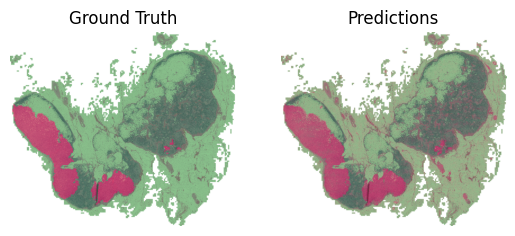

In [53]:
from torchmil.visualize import draw_heatmap_wsi

# normalize the predictions
y_inst_pred = (y_inst_pred - y_inst_pred.min()) / (y_inst_pred.max() - y_inst_pred.min())

canvas_labels = draw_heatmap_wsi(
    canvas,
    y_inst,
    10, 
    row_array,
    column_array,
)

canvas_pred = draw_heatmap_wsi(
    canvas,
    y_inst_pred,
    10, 
    row_array,
    column_array
)

# plot canvas side by side

fig, ax = plt.subplots(1, 2)
ax[0].imshow(canvas_labels)
ax[0].axis('off')
ax[0].set_title('Ground Truth')
ax[1].imshow(canvas_pred)
ax[1].axis('off')
ax[1].set_title('Predictions')
plt.show()

The heatmap shows the predicted scores for each instance, with red indicating high scores and green indicating low scores. Our model is able to detect the metastases in the WSI! Note that the model has learned to detect these regions without any instance-level labels, only using the bag-level labels. This is a clear example of the power of MIL in WSI classification tasks.